<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Neuroscience of Learning, Memory, Cognition <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 <br>
<font color=696880 size=4>

## AmirHossein Zahedi 99101705

---
# Finetuning CNN using regression loss

- CNN are proven to be a better model of visual cortex, but the goal of visual cortex is not limited to image classification.

- Typically, to model visual cortex responses using CNNs, we -

  1. Extract features of intermediate layers
  2. Reduce dimensionality of the data using techniques like PCA
  3. Perform regression to predict neural data.

- This approach fails to predict all the variance in the data.

**A better approach is to train CNNs directly on the neural response.**

- CNNs are built to somehow mimic the functionality of the visual system. They are able to achieve a high performance on many tasks, that were previously believed to be impossible for machines to solve. We are going to explore them in this assignment.

    1. Explain about the visual system, focusing on the data flow (You should explain the pathways in the visual system).

    2. What does each part of the visual system reveal about the stimuli (You should explain about the features that each part detects, like lines, angles, ...)?

    3. Compare the CNNs with the visual system. How are they alike and in which parts, do they converge?

    4. Explain about different learning strategies that we can deploy on the neural networks. What learning strategies have neurological evidence?

1 -> Visual system and its pathways: <br>
Our visual system comprises several components, beginning with the eye itself and extending to various regions of the brain. The visual pathway initiates with the rods and cones in the retina, which detect light and transmit information via nerve fibers to the brain. These nerve fibers from each eye diverge at the optic chiasm, ensuring each direction is directed to one hemisphere of the brain. Subsequently, visual information reaches the LGN in the thalamus, acting as a relay station that transmits information to the brain for processing. V1 is the first area that extracts preliminary data from the visual input, such as edges and their orientations. Beyond V1, higher-level areas specialize in processing motion and color information. <br>
There are two main pathways: the dorsal pathway, which is responsible for understanding motion and spatial location (answering the "where" question), and the ventral pathway, which identifies objects and characteristics (answering the "what" question, such as color or shape). For example, in the ventral pathway, we encounter areas like V1, V2, and V4, whereas the dorsal pathway includes V1, V2, V3 and V5 or MT. <br>
After all our brain has many parts in the visual system in order to extract information from the data which has been sensed with our eyes.

2 -> Feature extraction: <br>
In the retina, rods detect light intensity while cones respond to different colors. The first and most basic feature extraction occurs in the LGN. LGN neurons have small, simple receptive fields that detect changes in the visual input, helping to reduce the brain's computational load by filtering out repetitive information. In V1, basic features such as edges and line orientations are extracted, with neurons in V1 functioning like Gabor filters. As visual information proceeds through the processing stages, the receptive fields of neurons become larger, allowing for the extraction of more complex features. For instance, in V2 and V3, neurons detect angles, patterns, and motion depth. In V5, neurons analyze speed, while in V4, they focus on color. As we move to higher areas in the visual hierarchy, neurons respond to increasingly complex features and possess larger receptive fields.

3 -> CNN vs Visual system: <br>
Neurons in the visual system also function like filters, particularly convolutional filters. Both convolutional neural networks (CNNs) and the visual system have layers for feature extraction, with neurons or filters in each layer dedicated to specific features. These features become more complex as they progress through the layers. Both systems allow for parallel computing among neurons or filters, but the visual system is more general and robust against noise and changes. In contrast, CNNs require extensive learning and labeled data. <br>
The visual system is better suited for generalized purposes because our learning process begins at birth and continues for many years, making it more flexible than a CNN. This long-term, continuous learning enables the visual system to adapt and generalize more effectively than a CNN, which relies heavily on structured training datasets.

4 -> Neurological learnings: <br>
Different learning strategies like supervised, unsupervised, reinforcement, and transfer learning can be deployed and have neurological evidence. In supervised learning, we have some inputs and their labels to learn, and after that, we can classify a new input with its features. In unsupervised learning, patterns can be learned, and clustering happens. For example, you put similar things in a group and consider their shared feature as a marker of them, and if a new input comes, it can be grouped in a cluster. In reinforcement learning, choosing actions and receiving rewards or punishments based on those actions helps us learn about the action and its consequences. In transfer learning, a learning pattern established from past experiences can be applied to learning new tasks. <br>
Neurological evidence for these learning strategies can be found in Hebbian learning and synaptic strength, which can become stronger through repeated activation. Hebb famously said, "neurons that fire together, wire together," emphasizing the importance of co-activation in learning. Brain plasticity and the neuron's capacity to integrate inputs and reach a threshold for firing also provide evidence for these learning processes.

---
# Setup

We are now exploring some simple tasks using pytorch.

- We are going to use the following package : torch_intermediate_layer_getter.
Search What it does and why we do that ?
############## TO DO ###############


As its name suggests, this package in PyTorch facilitates the extraction of intermediate layer outputs from learning models. It allows us to obtain outputs from specific layers without modifying the model itself. Additionally, the package supports gradient tracking for these extracted features, which is crucial for tasks such as feature-based loss computations. This capability enables researchers and practitioners to delve deeper into model behavior and fine-tune performance based on intermediate representations without altering the core functionality of the model.

In [1]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install torch_intermediate_layer_getter --quiet

  Preparing metadata (setup.py) ... done


In [2]:
#  Imports
import copy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models


from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

# Add more if you need
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import torchvision
import torch.nn.functional as F

next cell download and extract data, for better understanding task search about dataset properties and write down results below:
############## TO DO ###############

The Kay dataset is utilized in computer vision and studies of the human brain's visual system. <br>
This dataset contains a large number of images depicting objects and natural scenes. These images were presented to subjects during an fMRI task, and the labels correspond to the images shown, enabling researchers to link the visual stimuli to the recorded brain activity during the fMRI scans. <br>
The images in this dataset have been preprocessed and resized. As shown in the code below, training labels are separated from validation labels. <br>
Ultimately, this image dataset can be used for decoding the neural visual system and training learning models, allowing for a comparison of their performance on the images shown. <br>
1725 training images, 120 test images, 8428 voxels, 8 regions of interest and voxels' activities for each image.


In [3]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

It is always a good idea to look at the data we are dealing with. Visualize some samples and plot them below.

Contents in dat:  dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


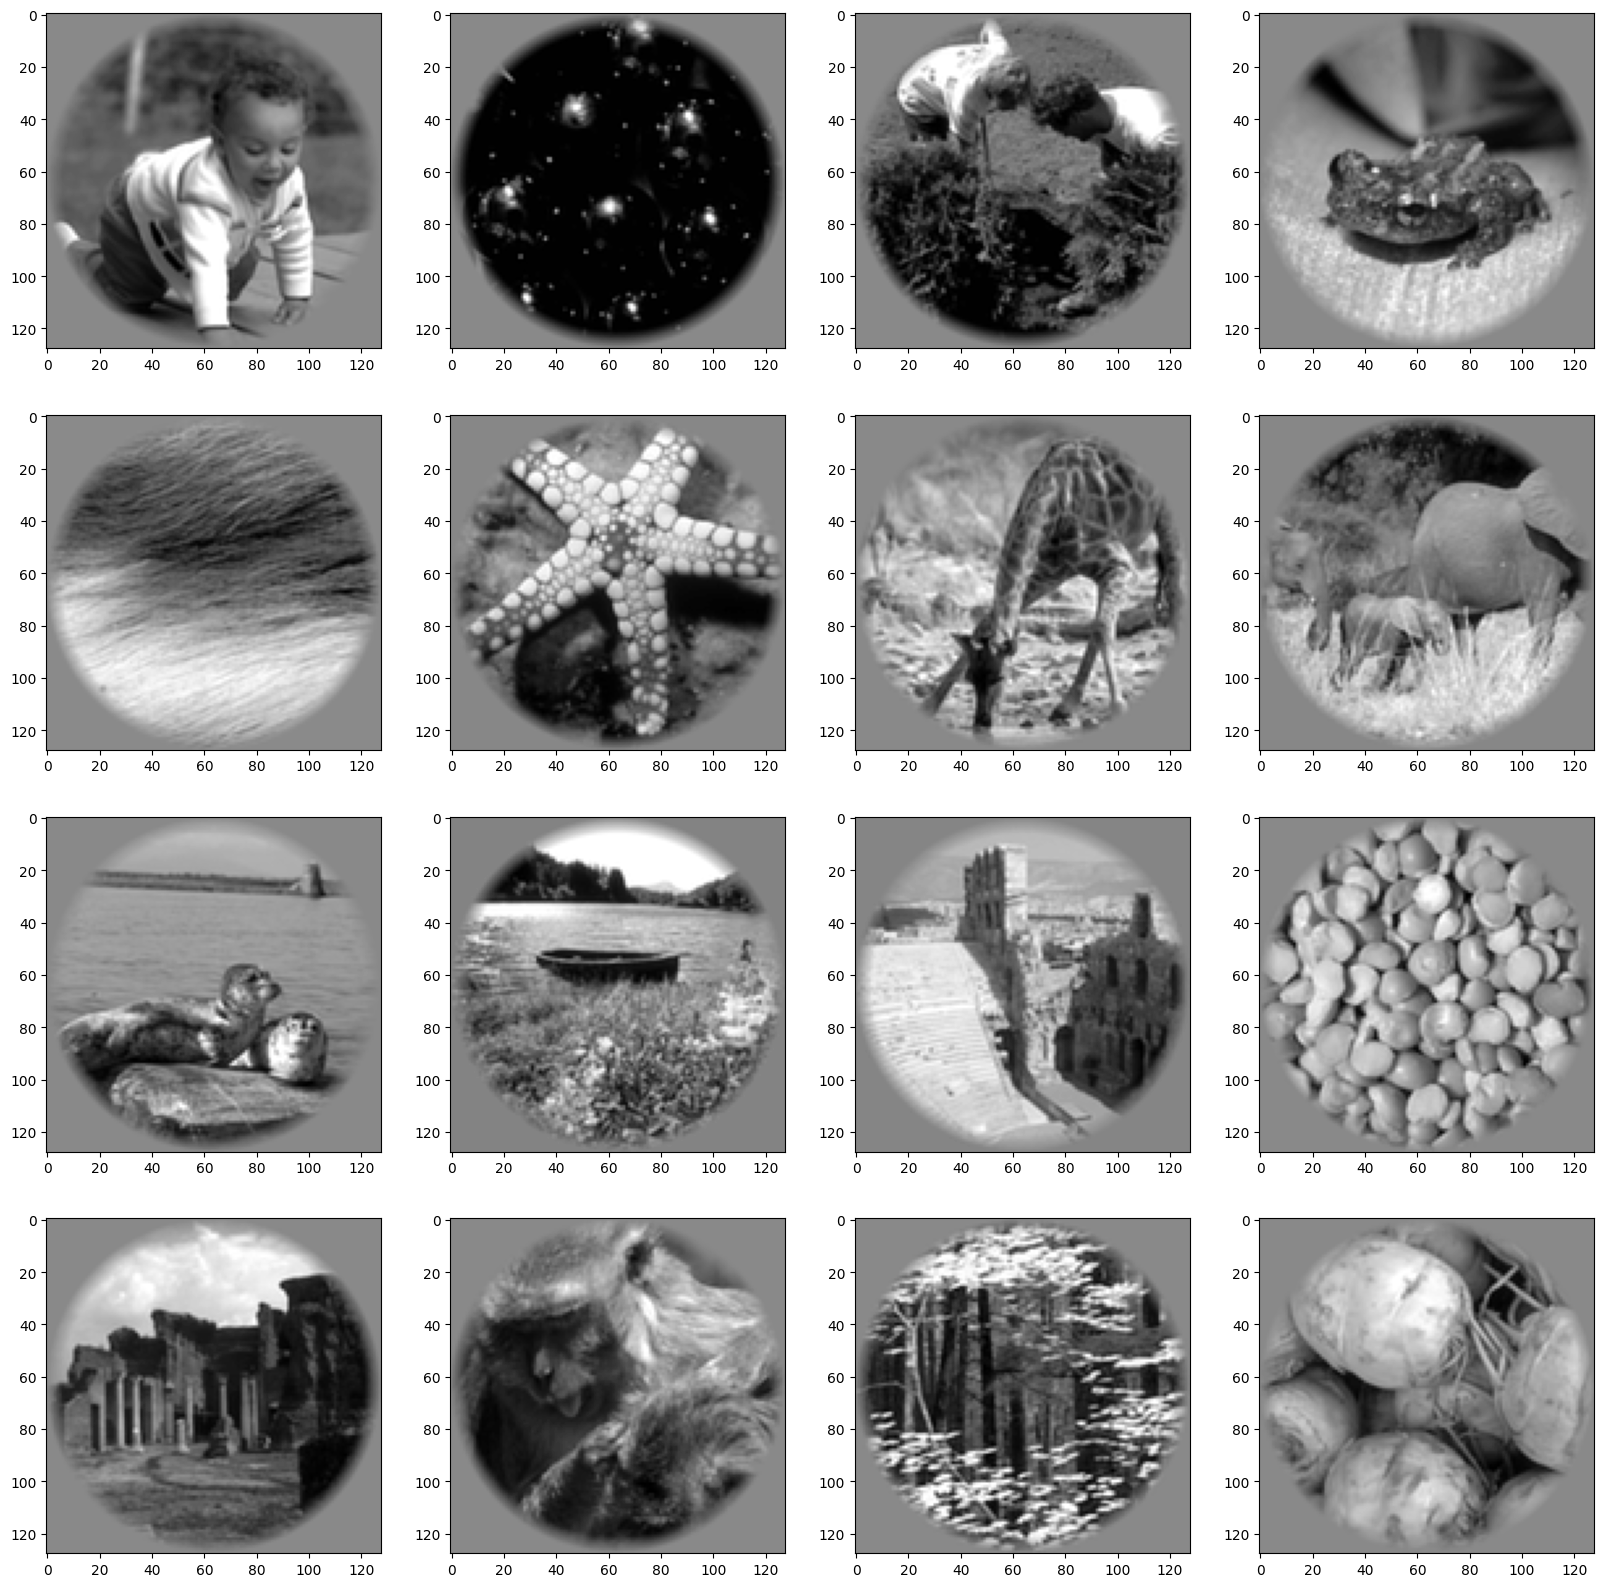

In [4]:
# @title Visualizing example images
############## TO DO ###############
print("Contents in dat: ", dat.keys())
images = dat['stimuli']
number_image = 16
plt.figure(figsize=(20, 20))
for i in range(number_image):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i], cmap='gray')
plt.show()

In this part we have plotted 16 images of the training dataset.

---
# Dataset Structure

While using the neural networks, we have to be careful about the dimensions and the stimuli we are feeding the network with.

`dat` has the following fields:  
- `stimuli`: stim $x_i \, \, x_j$ array of grayscale stimulus images
- `stimuli_test`: stim $x_i \, \, x_j$ array of grayscale stimulus images in the test set  
- `responses`: stim $x$ voxel array of $z$-scored BOLD response amplitude
- `responses_test`:  stim $x$ voxel array of $z$-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

Based of Letcures, describe roi and roi_names and match with the dataset?
############## TO DO ###############

ROI, or Region of Interest, refers to specific anatomical or functional areas of the brain that are selected for detailed study in tasks involving fMRI, EEG, or similar methodologies. <br>
In the context of this dataset used for fMRI tasks, ROIs contain spatial information about the voxels belonging to these areas.  <br>
The term "roi_names" likely denotes the names assigned to these regions of interest, which include key areas such as V1, V2, V3, V4, and V5/MT. This visual task dataset focuses on studying the activation of the visual system, particularly in regions of the occipital lobe associated with visual processing.


In [5]:
# Converting stimulus to RGB and changing the scale to 0-255 (Specific to Kay dataset images)
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128))
stimuli_ts_xformed = np.zeros((120, 3, 128, 128))
############## TO DO ###############

scaler = MinMaxScaler()

# Training stimuli
stimuli_tr_scaled = stimuli_tr
for i in range(1750):
    # Scaling
    stimuli_tr_scaled[i] = scaler.fit_transform(stimuli_tr[i]) * 255
    # Converting to RGB
    stimuli_tr_xformed[i] = np.stack((stimuli_tr_scaled[i],) * 3, axis=0)

# Test stimuli
stimuli_ts_scaled = stimuli_ts
for i in range(120):
    # Scaling
    stimuli_ts_scaled[i] = scaler.fit_transform(stimuli_ts[i]) * 255
    # Converting to RGB
    stimuli_ts_xformed[i] = np.stack((stimuli_ts_scaled[i],) * 3, axis=0)

print(stimuli_tr_scaled[0,0])

[255.       255.       231.52339  140.6711   119.32703  110.15681
 102.60433   89.95902   83.36574   78.025955  75.82489   74.47157
 129.22737  250.24774  250.52892  254.99998  255.       255.
 255.       255.       252.7089   252.78543  252.85703  252.82181
 255.       255.       255.       254.99998  255.       255.
 205.27837  166.52309  159.33247  147.21838  139.9155   133.78438
 134.72156  134.72156  135.64436  135.64436  134.72156  136.55309
 136.55309  136.55309  132.8325   131.86554  136.55309  136.55309
 136.55309  136.55309  136.55309  134.72156  129.88495  127.83962
 124.81037  121.72642  110.76869  112.972084 112.95685  116.43003
 115.37298  110.773125 105.1371   110.773125 128.02623  130.94872
 126.000175 120.712875 120.712875 118.57482  148.71132  155.33601
 152.76904  180.92609  192.39972  188.26775  202.81999  187.44118
 197.52422  214.9205   210.10207  191.44856  210.12564  207.49142
 210.85555  192.89027  160.29935  135.73087  118.4812   119.04614
 134.02173  122.5786

In this part we repeated gray scale image three times to make it semi RGB. new images also became scaled between 0 to 255. (Scaling was not needed because they were scaled.)

---
# Fine Tuning AlexNet on voxel activations





It is previously demonstrated that simple features are extracted in the early layers of the neural network, so it is a good idea to use pre-trained nets which are trained on enormous data sets and just modify the final layers.

1- Search about fine tuning. Why do we fine tune in the first place?

2- Search about different situations where fine tuning is done.

3- Name the different layers that are present in AlexNet. Briefly explain each layer's role. On what layers do we perform fine tuning>

1 -> Why fine tuning: <br>
Fine-tuning is a process in which we make small adjustments to weights of a pre-trained neural network. It has many uses for example, it enables transfer learning, where a model which has been pre-trained on a large dataset, can transfer learned features to new ones. It is not needed to train the model from the beginning. Maybe our new dataset is small and not enough for a good training, so there will be more efficient to just fine tune a pre-trained model and not to train it again. As an example of efficiency the initial layers of pre-trained models capture generic features like edges and textures that are useful for many tasks, so they can be used for many datasets. <br>
At last, fine-tuning often leads to better performance because the pre-trained model already captures a wide range of features from the extensive dataset it was originally trained on.


2 -> Situatins of fine tuning: <br>
As mentioned earlier, when working with a task that involves a dataset different from the one the model was originally trained on, fine-tuning can be highly effective, especially if the datasets are similar. Fine-tuning allows us to adapt a pre-trained model for our new data or task, which is particularly useful when we have a general model intended for multiple tasks. <br>
 This approach can significantly reduce computational costs, making it ideal in resource-limited situations. Additionally, when the new dataset is insufficient for training a deep model from scratch, fine-tuning a pre-trained model by adjusting some of its weights becomes the best option. <br>
 Overall, fine-tuning pre-trained models offers numerous advantages and is especially beneficial in scenarios with limited data or computational resources.

3 -> Layers of AlexNet: <br>
AlexNet is a CNN deep network that contains eight layers: the first five are convolutional layers, some of them followed by max-pooling layers, and the last three are fully connected layers. <br>
Input Takes input RGB images of size 227×227×3 (because it was made for ImageNet dataset). <br>
First Convolutional Layer (conv1) Applies 96 kernels of size 11×11×3 with a stride of 4 (shifting 4 pixels), followed by ReLU activation function (function of a neuron on its inputs); Detects low-level features like edges. <br>
Max-Pooling Layer (maxpool1) Reduces the spatial dimensions (height and width) by factor of 2 using max-pooling of size3×3 with stride of 2. <br>
Second Convolutional Layer (conv2) Applies 256 kernels of size 5×5×48, followed by ReLU activation. Captures more complex features like textures. <br>
Max-Pooling Layer (maxpool2) also reduces the spatial dimensions <br>
Third Convolutional Layer (conv3) Applies 384 kernels of size 3×3×256; Refines feature detection. <br>
Fourth Convolutional Layer (conv4) Applies 384 kernels of size 3x3x192; Focuses on more abstract features. <br>
Fifth Convolutional Layer (conv5) Applies 256 kernels of size 3x3x192; Detects even more abstract features. <br>
Max-Pooling Layer (maxpool3) Final reduction of spatial dimensions. <br>
Fully Connected Layers (fc6, fc7) Each layer has 4096 neurons, followed by ReLU and dropout for regularization. These layers integrate the high-level features detected by the convolutional layers. <br>
Output Layer (fc8) A softmax layer with 1000 neurons for classification into 1000 categories. <br>
So in summary: <br>
1- Conv1: 96 filters of size 11*11 with stride 4. <br>
2- MaxPool1: Pooling layer of size 3×3 with stride 2. <br>
3- Conv2: 256 filters of size 5×5. <br>
4- MaxPool2: Pooling layer of size 3×3 with stride 2. <br>
5- Conv3: 384 filters of size 3×3. <br>
6- Conv4: 384 filters of size 3×3. <br>
7- Conv5: 256 filters of size 3×3. <br>
8- MaxPool3: Pooling layer of size 3×3 with stride 2. <br>
9- Connected Layers (fc6, fc7): 4096 neurons <br>
10- Output Layer (fc8): 1000 neurons <br> <br>
First layers are used for simple features, so usually they are fixed. Convolutional and MaxPool layers can stay fixed because they find features that are not task-related and can be done on many images without any fine-tuning, but for fully connected layers, fine-tuning is needed. Last three layers which are fully connected, and they extract task-related features, so they should be adapted to the new dataset given.

In [6]:
# @title Setting up training and test data for LOC region (roi = 7)
############## TO DO ###############
LOC_indices = np.where(dat["roi"] == 7)

response_tr = dat["responses"][:, LOC_indices[0]]
response_ts = dat["responses_test"][:, LOC_indices[0]]

print(response_tr.shape)
print(response_ts.shape)

(1750, 928)
(120, 928)


For finding which voxels belong to LOC, we search for roi=7 in rois of voxels. Then fmri activity of voxels for LOC can be seperated from others.

When and Why we use transform function for dataset.
############## TO DO ###############

-> When we use transform function : Before feeding data into a neural network, it often needs to be preprocessed to ensure consistency and compatibility. Transform functions play a crucial role in this process by normalizing, resizing, and converting data into tensor format. <br>
 Sometimes for enhancing the diversity of the training dataset and prevent overfitting, transform functions can apply random transformations such as rotations, flips, crops, etc. <br>
Many ML algorithms require features to be on a similar scale, and transform functions help scale features to a specific range, which can improve the performance of the model. <br>
In computer vision tasks, transform functions can enhance the quality of images by adjusting brightness, contrast, and sharpness, leading to better feature extraction. <br> <br>

-> Why we use transform function : Normalization adjusts the scale of data to a common range, like [0, 1], which helps neural networks perform better and converge faster. For example, standardizing pixel values to a mean of 0 and a standard deviation of 1. <br>
Resizing changes the dimensions of images to match the input size expected by the neural network, ensuring consistency since most architectures expect a fixed size, like resizing all images to 227x227 for models like AlexNet. <br>
Data augmentation applies random transformations like rotations, flips, and color changes to images, creating a more robust model by training it on a variety of altered versions of the data, thus reducing overfitting and improving generalization. <br>
Tensor conversion involves converting data to tensors, as libraries like PyTorch and TensorFlow require data to be in tensor format for efficient GPU processing.

In [7]:
# @title Custom dataloader for loading images in numpy array
# use MyDatast or use your own dataloader.
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.LongTensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)

############## TO DO ###############
# complete transforms
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]),

    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]),
}

dataset = {}
dataset['train'] = MyDataset(list(stimuli_tr_xformed),
                             list(response_tr), transform=transform['train'])
dataset['val'] = MyDataset(list(stimuli_ts_xformed),
                           list(response_ts), transform=transform['val'])
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=120) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<ipython-input-7-386e51be705b>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  self.targets = torch.LongTensor(targets)


Some transformations were applied to both the training and validation images. For both sets, the images were resized to a square of 128 pixels, normalized to a mean of 0.5 and a variance of 0.5 for each of the R, G, and B channels, and converted to tensors to be compatible with the PyTorch library. <br>
However, for the training images, additional transformations were performed to make the model more robust against noise and rotations. This included adding random rotations, flips and crops to the images, enhancing the model's ability to generalize and perform well on unseen data.

In [8]:
# Training on pretrained alexnet and find best wieghts on epochs,
#finally load best weights
############## TO DO ###############

##### Loading  and preparing AlexNet #####
model = models.alexnet(pretrained=True)

# Changing output fullly connected layer neurons for our dataset features; inputs of the last layer won't change
kay_features = np.size(response_tr,1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, kay_features)


# Computing model in the cpu or cuda
model = model.to(device)

# Loss function  that measures the error between the predicted class scores and the actual class labels (mean squared error)
loss_func = nn.MSELoss()

# Optimizer that updates the model parameters based on the computed gradients during training (stochastic gradient optimizer)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


##### Training #####
epochs = 8
best_error = 1000
best_weights = copy.deepcopy(model.state_dict())

# Repeating train test cycle and finding best weights based on best accuracy
for t in range(epochs):
    print('\nEpoch', t + 1, ':')

    ## Training
    model.train()

    online_loss = 0
    # Iterate over data.
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Setting gradients to 0
        optimizer.zero_grad()

        # Forward
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

        # Statistics
        online_loss += loss.item() * inputs.size(0)

    epoch_loss = online_loss / dataset_sizes['train']

    print('train ->  Loss:', epoch_loss)


    ## Validating
    model.eval()

    online_loss = 0
    # Iterate over data.
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

        # Statistics
        online_loss += loss.item() * inputs.size(0)

    epoch_loss = online_loss / dataset_sizes['val']

    print('val ->  Loss:', epoch_loss)

    # Deep copy the model
    if epoch_loss < best_error:
        best_error = epoch_loss
        best_weights = copy.deepcopy(model.state_dict())

print('\nBest validation Error:', best_error)

# Saving best weights
model.load_state_dict(best_weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 223MB/s]



Epoch 1 :
train ->  Loss: 0.7077214322771345
val ->  Loss: 0.13981924951076508

Epoch 2 :
train ->  Loss: 0.4979171235220773
val ->  Loss: 0.07042836397886276

Epoch 3 :
train ->  Loss: 0.47678214924676077
val ->  Loss: 0.06090795621275902

Epoch 4 :
train ->  Loss: 0.4728300639561244
val ->  Loss: 0.05800923332571983

Epoch 5 :
train ->  Loss: 0.4715419486590794
val ->  Loss: 0.05656670778989792

Epoch 6 :
train ->  Loss: 0.47070301396506176
val ->  Loss: 0.055654074996709824

Epoch 7 :
train ->  Loss: 0.4703047674042838
val ->  Loss: 0.0549888014793396

Epoch 8 :
train ->  Loss: 0.4698341362816947
val ->  Loss: 0.05448004603385925

Best validation Error: 0.05448004603385925


<All keys matched successfully>

First we define our model which is pre-trained AlexNet model. Then we change output layer dimension to LOC voxels' activations. Then we define loss function and stochastic gradient optimizer for updating model weights based on training new dataset. <br>
For fine tuning, training and testing will repeat 5 times. In each epoch, model will be trained  and validated. In training process, weights will be tuned for our dataset by backward propagation. In validation, error will be checked by using predictions and labels and best weights corresponding to least error make our best model. <br>
Error rate of 0.05 shows a good training and validation.

why we extract intermediate layers freatures ?
############## TO DO ###############

We know that layers in a deep network progressively extract more complex features, allowing us to understand how the network works and processes data by examining the features of intermediate layers. This can be useful for debugging or visualization, such as understanding how gradients work, identifying if overfitting or underfitting is occurring, and analyzing the model's decision-making process. <br>
Intermediate features are often used in transfer learning and fine-tuning. When using a pre-trained model as a fixed feature extractor, the outputs of intermediate layers are fed into a new classifier. Additionally, to adjust the weights of the pre-trained model for better performance on a new task, extracting intermediate features is helpful. This approach leverages the learned features from the pre-trained model, facilitating improved performance and adaptation to new datasets.

In [9]:
## Extract features of all the intermediate layers from ImageNet-trained and finetuned Alexnet
return_layers = {
    'features.2': 'conv1',
    'features.5': 'conv2',
    'features.7': 'conv3',
    'features.9': 'conv4',
    'features.12': 'conv5',
    'classifier.1': 'fc1',
    'classifier.4': 'fc2',
    'classifier.6': 'fc3',
    }

# Loading AlexNet pretrained on Imagenet
############## TO DO ###############
# pre-trained
model_pretrained = models.alexnet(pretrained=True)
model_pretrained.to(device)
# Fine-tuned
model_finetuned = model
model_finetuned.to(device)

# Setting up feature extraction step
############## TO DO ###############
# pre-trained
extractor_pretrained = MidGetter(model_pretrained, return_layers, keep_output=False)
# Fine-tuned
extractor_finetuned = MidGetter(model_finetuned, return_layers, keep_output=False)

# Loading validation data and forward pass through the network
############## TO DO ###############
# pre-trained
features_pretrained = {name: [] for name in return_layers.values()}
print("Pre-trained -> Extracted features:")
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = extractor_pretrained(inputs)
        output = outputs[0]
        for name in return_layers.values():
            print(name,' : ',output[name].shape)
            features_pretrained[name].append(output[name])

# Fine-tuned
features_finetuned = {name: [] for name in return_layers.values()}
print("\nFine-tuned -> Extracted features:")
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = extractor_finetuned(inputs)
        output = outputs[0]
        for name in return_layers.values():
            print(name,' : ',output[name].shape)
            features_finetuned[name].append(output[name])


Pre-trained -> Extracted features:
conv1  :  torch.Size([120, 64, 15, 15])
conv2  :  torch.Size([120, 192, 7, 7])
conv3  :  torch.Size([120, 384, 7, 7])
conv4  :  torch.Size([120, 256, 7, 7])
conv5  :  torch.Size([120, 256, 3, 3])
fc1  :  torch.Size([120, 4096])
fc2  :  torch.Size([120, 4096])
fc3  :  torch.Size([120, 1000])

Fine-tuned -> Extracted features:
conv1  :  torch.Size([120, 64, 15, 15])
conv2  :  torch.Size([120, 192, 7, 7])
conv3  :  torch.Size([120, 384, 7, 7])
conv4  :  torch.Size([120, 256, 7, 7])
conv5  :  torch.Size([120, 256, 3, 3])
fc1  :  torch.Size([120, 4096])
fc2  :  torch.Size([120, 4096])
fc3  :  torch.Size([120, 928])


In this part we extract features (outputs) of each layer of both pre-trained and fine-tuned AlexNet.

LOC Dissimilarity Matrix: (928, 928)
V1 Dissimilarity Matrix: (1294, 1294)


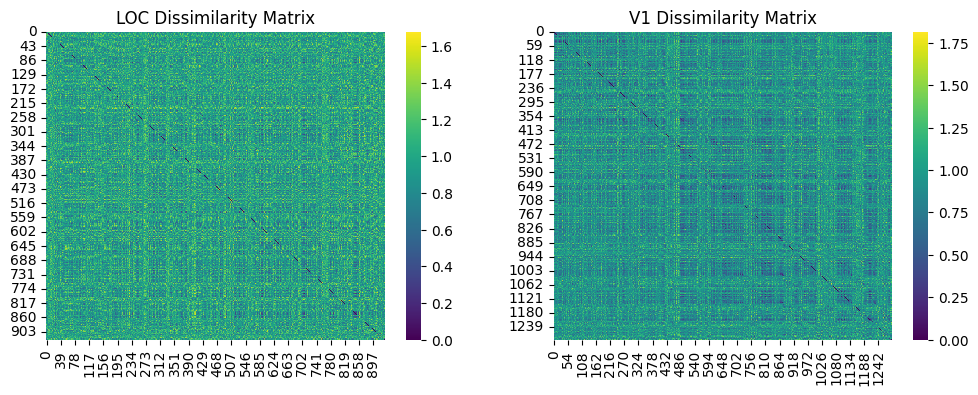

Pre-trained Dissimilarity Matrix  conv1 : torch.Size([14400, 14400])
Pre-trained Dissimilarity Matrix  conv2 : torch.Size([9408, 9408])
Pre-trained Dissimilarity Matrix  conv3 : torch.Size([18816, 18816])
Pre-trained Dissimilarity Matrix  conv4 : torch.Size([12544, 12544])
Pre-trained Dissimilarity Matrix  conv5 : torch.Size([2304, 2304])
Pre-trained Dissimilarity Matrix  fc1 : torch.Size([4096, 4096])
Pre-trained Dissimilarity Matrix  fc2 : torch.Size([4096, 4096])
Pre-trained Dissimilarity Matrix  fc3 : torch.Size([1000, 1000])
Fine-tuned Dissimilarity Matrix  conv1 : torch.Size([14400, 14400])
Fine-tuned Dissimilarity Matrix  conv2 : torch.Size([9408, 9408])
Fine-tuned Dissimilarity Matrix  conv3 : torch.Size([18816, 18816])
Fine-tuned Dissimilarity Matrix  conv4 : torch.Size([12544, 12544])
Fine-tuned Dissimilarity Matrix  conv5 : torch.Size([2304, 2304])
Fine-tuned Dissimilarity Matrix  fc1 : torch.Size([4096, 4096])
Fine-tuned Dissimilarity Matrix  fc2 : torch.Size([4096, 4096])


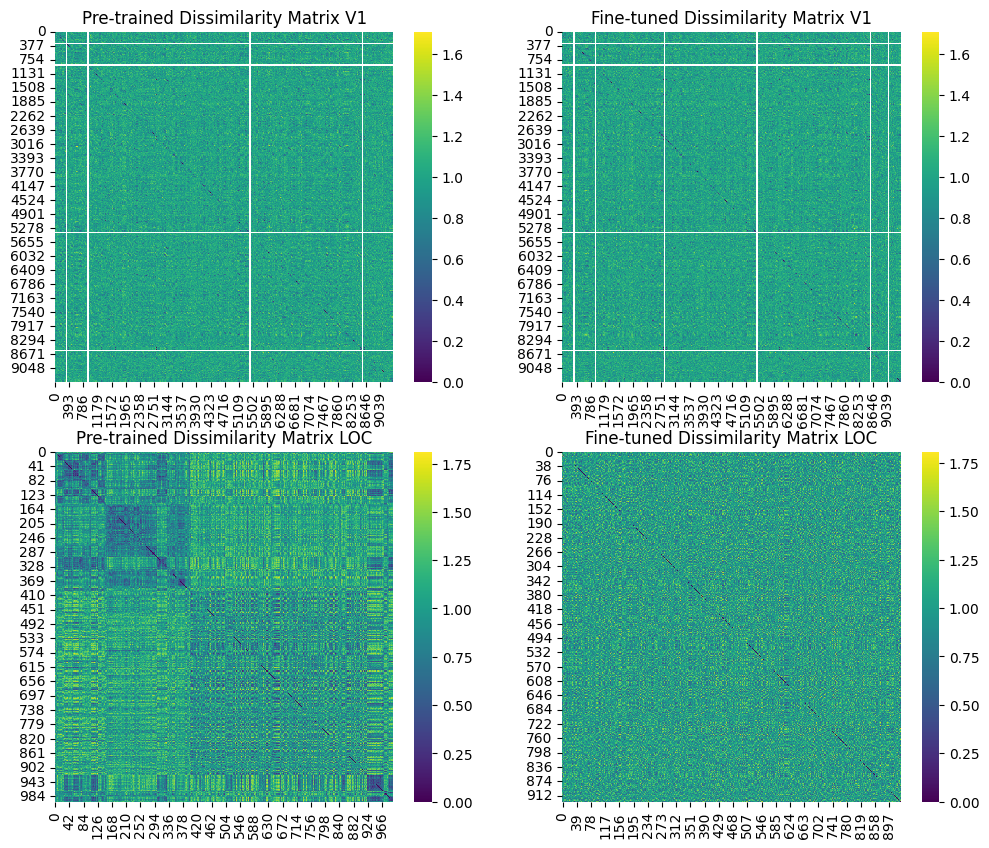

In [10]:
def torch_corrcoef(x):
        mean_x = torch.mean(x, dim=0)
        xm = x - mean_x
        c = xm.t() @ xm / (x.size(0) - 1)
        d = torch.diag(c)
        stddev = torch.pow(d, 0.5)
        c = c / stddev[:, None]
        c = c / stddev[None, :]
        return c


# @title Dissimilarity - Correlation
# Loading V1 (roi = 1) and LOC (roi = 7) responses
############## TO DO ###############
LOC_indices = np.where(dat["roi"] == 7)
V1_indices = np.where(dat["roi"] == 1)

response_LOC = dat["responses_test"][:, LOC_indices[0]]
response_V1 = dat["responses_test"][:, V1_indices[0]]

# Observed dissimilarity  - Correlation
############## TO DO ###############
# Computing correlation matrixes
corr_LOC = np.corrcoef(response_LOC, rowvar=False)
corr_V1 = np.corrcoef(response_V1, rowvar=False)

# Computing dissimilarity matrixes
dissim_LOC = 1 - corr_LOC
dissim_V1 = 1 - corr_V1

print("LOC Dissimilarity Matrix:", dissim_LOC.shape)
print("V1 Dissimilarity Matrix:", dissim_V1.shape)

# Plotting the LOC dissimilarity matrix
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(dissim_LOC, cmap='viridis')
plt.title('LOC Dissimilarity Matrix')

# Plotting the V1 dissimilarity matrix
plt.subplot(1,2,2)
sns.heatmap(dissim_V1, cmap='viridis')
plt.title('V1 Dissimilarity Matrix')
plt.show()

# Comparing representation of V1 and LOC across different layers of Alexnet
############## TO DO ###############

# Calculating correlation and dissimilarities of features of each layers in both
# pre-trained nad fine-tuned models
all_dissim_LOC_pretrained = {name: [] for name in return_layers.values()}
for name in return_layers.values():
    layer_features = features_pretrained[name][0]
    reshaped_layer_features = layer_features.reshape(120, -1)
    corr_LOC_pretrained = torch_corrcoef(reshaped_layer_features)
    dissim_LOC_pretrained = 1 - corr_LOC_pretrained
    print('Pre-trained Dissimilarity Matrix ',name,':', dissim_LOC_pretrained.shape)
    all_dissim_LOC_pretrained[name] = dissim_LOC_pretrained

all_dissim_LOC_finetuned = {name: [] for name in return_layers.values()}
for name in return_layers.values():
    layer_features = features_finetuned[name][0]
    reshaped_layer_features = layer_features.reshape(120, -1)
    corr_LOC_finetuned = torch_corrcoef(reshaped_layer_features)
    dissim_LOC_finetuned = 1 - corr_LOC_finetuned
    print('Fine-tuned Dissimilarity Matrix ',name,':', dissim_LOC_finetuned.shape)
    all_dissim_LOC_finetuned[name] = dissim_LOC_finetuned


# Plotting dissimilarity matrixes of AlexNet models
plt.figure(figsize=(12, 10))

# Pre-trained
plt.subplot(2,2,1)
sns.heatmap(all_dissim_LOC_pretrained['conv2'].cpu().numpy(), cmap='viridis')
plt.title('Pre-trained Dissimilarity Matrix V1' )

plt.subplot(2,2,3)
sns.heatmap(all_dissim_LOC_pretrained['fc3'].cpu().numpy(), cmap='viridis')
plt.title('Pre-trained Dissimilarity Matrix LOC' )

# Fine-tuned
plt.subplot(2,2,2)
sns.heatmap(all_dissim_LOC_finetuned['conv2'].cpu().numpy(), cmap='viridis')
plt.title('Fine-tuned Dissimilarity Matrix V1')

plt.subplot(2,2,4)
sns.heatmap(all_dissim_LOC_finetuned['fc3'].cpu().numpy(), cmap='viridis')
plt.title('Fine-tuned Dissimilarity Matrix LOC' )

plt.show()


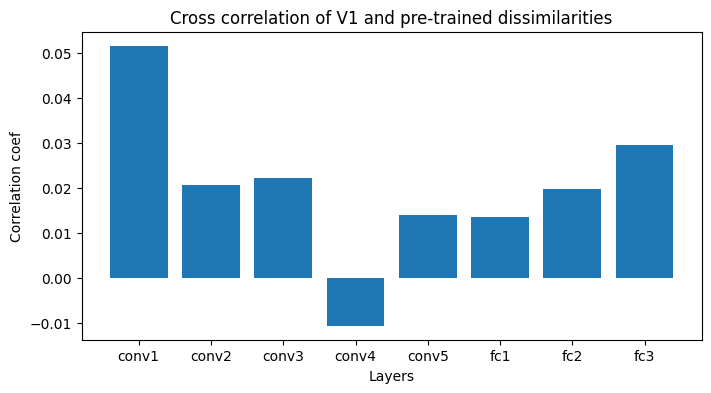

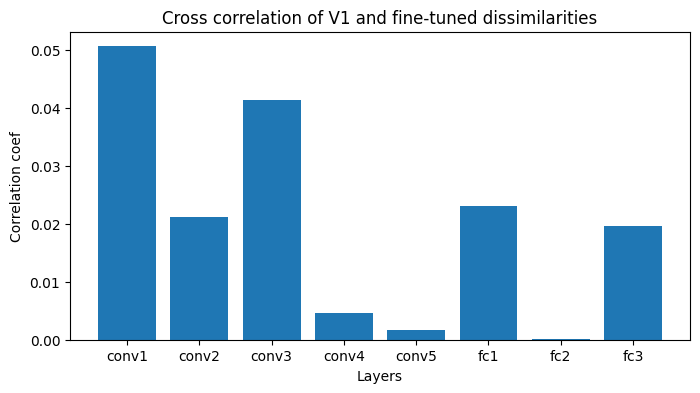

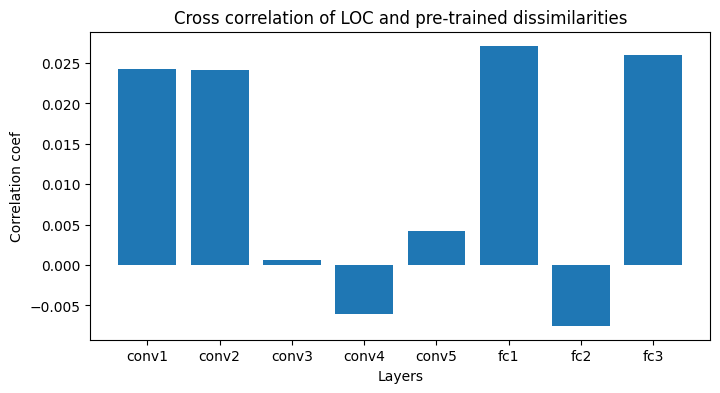

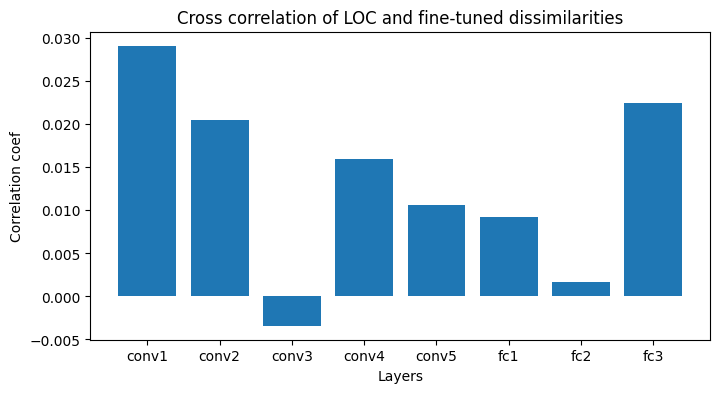

In [48]:
# @title Plotting correlation between observed and predicted dissimilarity values
############## TO DO ###############
def compare_with_brain_regions(brain_dissimilarity, model_dissimilarities, brain_region_name, model_name):
    correlation_results = {}
    N = np.size(brain_dissimilarity,0)
    for name in return_layers.values():
        # Compute correlation between brain region and model layer dissimilarities
        model_dissimilarity = model_dissimilarities[name]
        model_dissimilarity = model_dissimilarity.unsqueeze(0).unsqueeze(0)
        model_dissimilarity = F.interpolate(model_dissimilarity, size=(N, N), mode='bilinear', align_corners=False)
        model_dissimilarity = model_dissimilarity.squeeze().cpu().numpy()
        model_dissimilarity = model_dissimilarity.reshape(1,N*N)
        brain_dissimilarity = brain_dissimilarity.reshape(1,N*N)
        model_dissimilarity = np.nan_to_num(model_dissimilarity, nan=0)
        brain_dissimilarity = np.nan_to_num(brain_dissimilarity, nan=0)
        correlation = np.corrcoef(brain_dissimilarity, model_dissimilarity)[0,1]
        correlation_results[name] = correlation
    # Plot the correlation results
    plt.figure(figsize=(8, 4))
    plt.bar(correlation_results.keys(), correlation_results.values())
    plt.title('Cross correlation of ' + brain_region_name + ' and ' + model_name + ' dissimilarities')
    plt.xlabel('Layers')
    plt.ylabel('Correlation coef')
    plt.show()

# Comparing V1 with pre-trained and fine-tuned models
compare_with_brain_regions(dissim_V1, all_dissim_LOC_pretrained, 'V1','pre-trained')
compare_with_brain_regions(dissim_V1, all_dissim_LOC_finetuned, 'V1','fine-tuned')

# Comparing LOC with pre-trained and fine-tuned models
compare_with_brain_regions(dissim_LOC, all_dissim_LOC_pretrained, 'LOC','pre-trained')
compare_with_brain_regions(dissim_LOC, all_dissim_LOC_finetuned, 'LOC','fine-tuned')

**Describle Results in details :**

In the previous two parts, I calculated the correlation and dissimilarity matrices of responses for voxels in V1 and LOC. Using both pre-trained and fine-tuned AlexNet models, I also calculated the correlation and dissimilarity matrices of the outputs for each layer, which required significant RAM storage. <br>
In the final part, I attempted to find cross-correlation matrices between the response matrices and the model matrices. However, due to the dimensional mismatch between the layers of the model and the voxel responses, I was unable to proceed as planned. I also used interpolation but the results are not good enough<br>
If the result was correct and I could calculate the cross-correlations, I would expect to see a similarity between the responses of voxels in V1 and the initial layers of the model, especially layer 1 (conv2). Similarly, I would expect to find a similarity between the responses of voxels in LOC and the final layers of the model, particularly the output layer (fc3). This expectation arises because our visual system processes information through a gradual path from V1 to V2, then V3, and finally LOC. The AlexNet model attempts to simulate this hierarchical processing through its convolutional and fully connected layers, mirroring the complexity and depth of feature extraction seen in the human visual system. <br> <br>
Plots similar to these plots were expected.

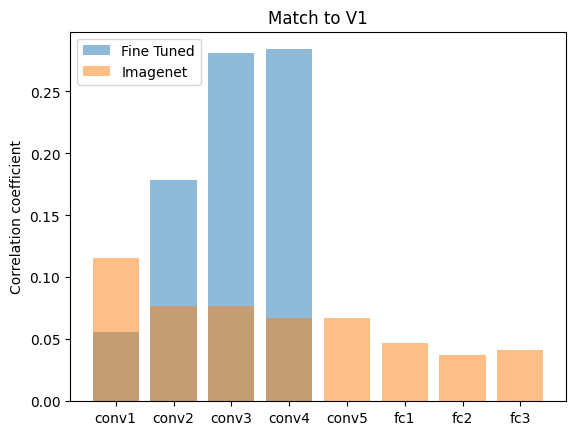

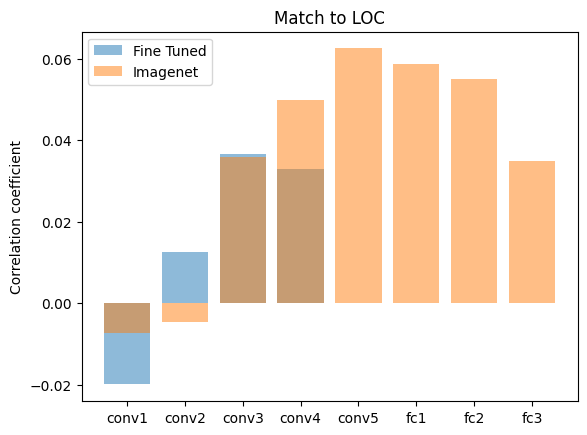